In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/COVIDPatient.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import folium
from sklearn.cluster import KMeans
import matplotlib as mpl

Description:
This data provides information about the COVID-19 about the patients, containment areas, Hospital details, Quarantine facilities and Food shelter distribution details etc.

Released Under:
National Data Sharing and Accessibility Policy (NDSAP)

Contributor:
Maharashtra Thane

Sectors:
HealthFamily WelfareHealth and Family welfare

Published on Data Portal:
June 30, 2020

In [3]:
data = pd.read_csv('/kaggle/input/COVIDPatient.csv')

In [4]:
data.head()

,State,City Name,Patients_ID,Result Date,Sample Result,Age,Gender,Ward Name,Ward Number,Current Status,Locally Acquired Yes/No,Acquired Overseas: Yes/No,Latitude,Longitude,Contact Determined
0,Maharashtra,Thane,1633,5/22/2020,COVID 19 Positive,28,F,Mumbra Prabhag Samiti,8,Discharge,Yes,No,73.032935,19.152825,Under Investigation
1,NaN,NaN,4715,06-11-2020,COVID 19 Positive,60,F,Diva Prabhag Samiti,9,Discharge,Yes,No,73.046687,19.152849,Under Investigation
2,NaN,NaN,2039,5/24/2020,COVID 19 Positive,55,F,Mumbra Prabhag Samiti,8,Discharge,Yes,No,73.025268,19.169553,Under Investigation
3,NaN,NaN,1460,5/20/2020,COVID 19 Positive,38,F,Lokmanya-Savarkar Prabhag Samiti,4,Discharge,Yes,No,72.952036,19.205854,Under Investigation
4,NaN,NaN,3827,06-06-2020,COVID 19 Positive,48,M,Uthalsar Prabhag Samiti,1,Discharge,Yes,No,72.979147,19.209893,Under Investigation


* lets remove the unneccessary colums which are 'State', 'City Name' and 'Contact Determined' contains only one value each. i.e. Maharastra Thane and Under Investigation Respectively
* we are removing 'Locally Acquired Yes/No', 'Acquired Overseas: Yes/No' columns as well because all patients acquired corona Locally

In [5]:
unneccesary_cols = ['State', 'City Name','Locally Acquired Yes/No', 'Acquired Overseas: Yes/No', 'Contact Determined']

In [6]:
data_ = data.drop(unneccesary_cols, axis=1)

In [7]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7054 entries, 0 to 7053
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patients_ID     7054 non-null   int64  
 1   Result Date     7054 non-null   object 
 2   Sample Result   7054 non-null   object 
 3   Age             7054 non-null   object 
 4   Gender          7054 non-null   object 
 5   Ward Name       7054 non-null   object 
 6   Ward Number     7054 non-null   object 
 7   Current Status  7054 non-null   object 
 8   Latitude        7054 non-null   float64
 9   Longitude       7054 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 551.2+ KB


# Age Columns dtype is Object lets convert it to float 

1. first converted "Not Available" values in Age column to "0"
2. converted dtype object to float
3. replaced all zero values with mean of Age.

In [8]:
age = data_["Age"]
for i in range(0,7054):
    if age[i] == 'Not Available' :
        age[i] = '0'
        
data_["Age"] = data_["Age"].astype(str).astype(float)

age = data_["Age"]
for i in range(0,7054):
    if age[i] == '0' :
        age[i] = age.mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7054 entries, 0 to 7053
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patients_ID     7054 non-null   int64  
 1   Result Date     7054 non-null   object 
 2   Sample Result   7054 non-null   object 
 3   Age             7054 non-null   float64
 4   Gender          7054 non-null   object 
 5   Ward Name       7054 non-null   object 
 6   Ward Number     7054 non-null   object 
 7   Current Status  7054 non-null   object 
 8   Latitude        7054 non-null   float64
 9   Longitude       7054 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 551.2+ KB


# Lets check the number of positive cases with respect to Gender

M                4361
F                2686
Not Available       7
Name: Gender, dtype: int64

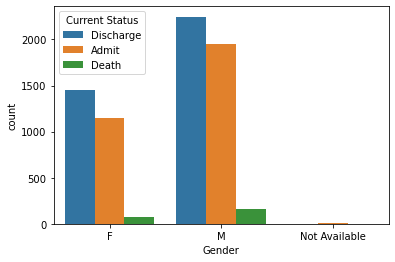

In [10]:
sns.countplot(data['Gender'],hue = data['Current Status'])
data['Gender'].value_counts()

# Lets check the current status of the patients

Discharge    3704
Admit        3109
Death         241
Name: Current Status, dtype: int64

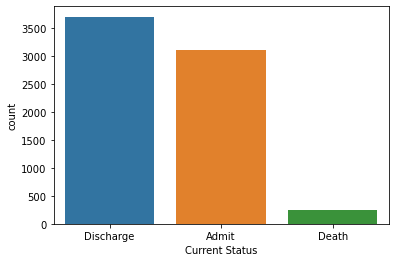

In [11]:
sns.countplot(data['Current Status'])
data['Current Status'].value_counts()

# lets see number of patients in various containment area wards

Not Available                       2069
Lokmanya-Savarkar Prabhag Samiti    1078
Wagle Prabhag Samiti                 844
Mumbra Prabhag Samiti                701
Naupada -Kopari Prabhag Samiti       620
Kalwa Prabhag Samiti                 543
Uthalsar Prabhag Samiti              441
Vartaknagar Prabhag Samiti           302
Majiwada-Manpada Prabhag Samiti      298
Diva Prabhag Samiti                  158
Name: Ward Name, dtype: int64

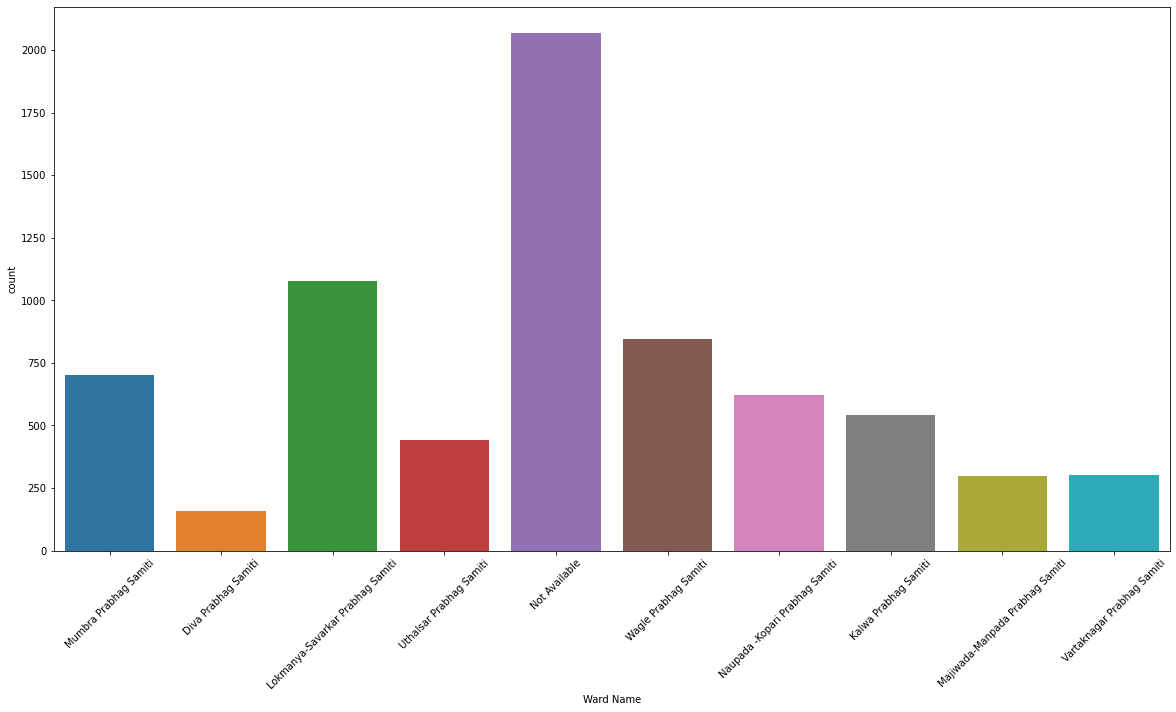

In [12]:
plt.figure(figsize=(20,10))

sns.countplot(data['Ward Name'])
plt.xticks(rotation=45)
data['Ward Name'].value_counts()

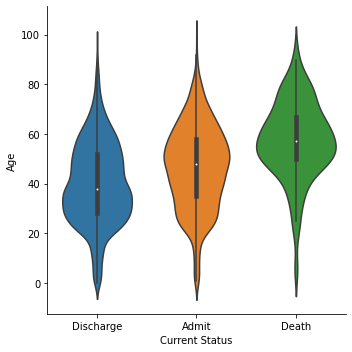

In [13]:
sns.catplot(x="Current Status", y="Age", kind="violin", data=data_)

we can see that as age increases discharge rate decreases and death rate increases 

* we have Result Date column values in 2 formats containg - and / in between 
* lets replace all - in Result Date to /
* lets sort data_ with respect to Result Dates

In [14]:
import re
data_["Result Date"] = data_["Result Date"].replace(to_replace ='-', value = '/', regex = True) 

In [15]:
data_['Result Date'] = pd.to_datetime(data_['Result Date'],errors='coerce').dt.date

In [16]:
df = data_.sort_values('Result Date')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86]),
 <a list of 87 Text major ticklabel objects>)

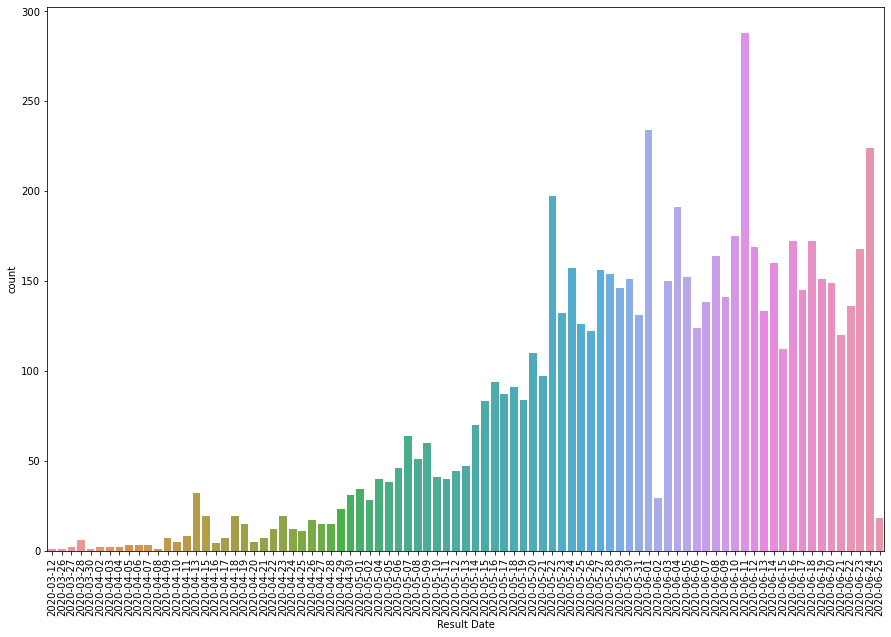

In [17]:
plt.figure(figsize=(15,10))
sns.countplot(df['Result Date'])
plt.xticks(rotation=90)

# Let's use the longitude and latitude values so that we can plot them and get insights on clustering.

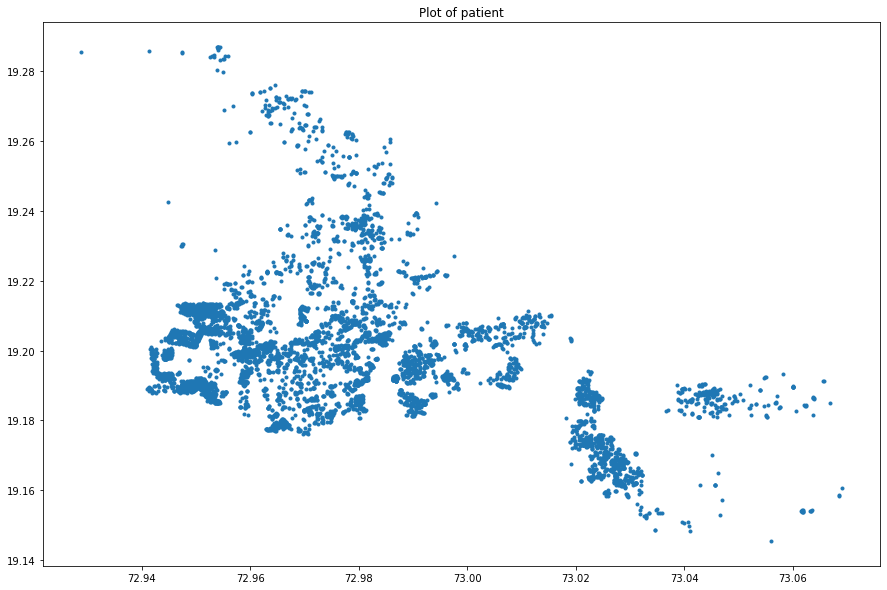

In [18]:
plt.figure(figsize=(15,10))
plt.plot(data['Latitude'], data['Longitude'],'.')
plt.title('Plot of patient')
plt.show()

# Testing Different Numbers of Clusters
We will try out different number of clusters using KMeans clustering and then decide what the best number of clusters is by seeing when the SSE score stops improving significantly.

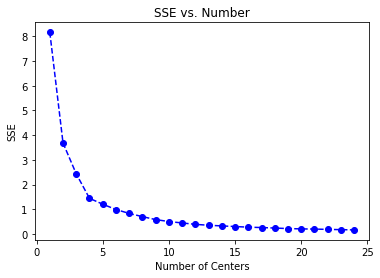

In [19]:
def get_kmeans_score(data_, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
  
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data_)
    score = np.abs(model.score(data_))
    
    return score

scores = []
centers = list(range(1,25))

for center in centers:
    scores.append(get_kmeans_score(data.loc[: ,['Longitude','Latitude']], center))
    
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of Centers');
plt.ylabel('SSE');
plt.title('SSE vs. Number');

So it looks like we have 4 clusters, according to the elbow method, since after 4 there is insignificant improvement. Now let's find their coordinates so that we can plot them on the map as well.

In [20]:
kmeans = KMeans(n_clusters=4)

kmeans.fit(data.loc[: ,['Longitude','Latitude']]).cluster_centers_

array([[19.19837831, 72.95482235],
       [19.19783793, 72.98635121],
       [19.2414287 , 72.97456634],
       [19.17479723, 73.03017528]])

In [21]:
m = folium.Map(location=[19.198741,72.977948])

In [22]:
folium.Marker([19.19784481, 72.98635878],popup = 'Cluster Center', icon=folium.Icon(color='red') ).add_to(m)
folium.Marker([19.17479723, 73.03017528],popup = 'Cluster Center', icon=folium.Icon(color='red') ).add_to(m)
folium.Marker([19.19837351, 72.95482727],popup = 'Cluster Center', icon=folium.Icon(color='red') ).add_to(m)
folium.Marker([19.2414287 , 72.97456634],popup = 'Cluster Center', icon=folium.Icon(color='red') ).add_to(m)

In [23]:
m